Sparse Identification of Nonlinear Dynamics. 

Cavity Galerkin

The dataset used is from the pysindy dynamics github repository published by Dr. Steve Brunton. 

The dataset is for Galerkin fluid dynamics system.

What I tried to do is to discover the reduced order ODEs governing the system. The first problem I faced is that for each time step there is a very large number of coupled modal interactions, making the system so computationally expensive. That's because the equations' form is quadratic and nonlinear. I had to crop the data both in time and in the number of modes, but this had a negative effect on pysindy since now there isn't enough data to train the model and generalize well. As an initial solution I tried using Principal Component Analysis (PCA) as a dimensionaloty reduction tool to project the system on lower dimensions that'll conserve the maximum variance of the data. This allowed SINDy to focus on the major axes. I Used Smoothed Finite Difference differentiation for the numerical derivatives and STLSQ as the optimizer. Varying the threshold for the optimizer, I decided on the 2 thresholds below which are 3 and 4 since decreasing the thresholds will increase the computational cost exponentially. Through the visualization it's revealed that this algorithm picked up trends of some ODEs, however it was limited by the computational power (cropped data) which is why it didn't generalize well on all ODEs.

Original A shape: (500, 64)
Number of PCA components to capture 95% variance: 27
Selected major physical modes (indices in original A): [17  5 31 21 26 15  0 27  3  2 10 20  8 30  9 19  1 18 11  4]
Threshold 3: sparsity = 53

Best threshold: 3
(a18)' = 8.343 a32
(a6)' = -3.797 a5
(a32)' = 15.725 a31
(a22)' = 18.310 a21
(a27)' = -5.787 a28 + 7.897 a21
(a16)' = -6.465 a4 + -7.167 a21 + -4.294 a9 + -4.580 a12
(a1)' = -10.960 a2
(a28)' = 13.017 a27
(a4)' = 3.314 a16 + 22.024 a3
(a3)' = -17.971 a32 + -23.897 a4 + -8.312 a3 + -18.342 a21 + -5.993 a9 + -5.060 a31 + 0.694 a10
(a11)' = 9.296 a21 + -6.240 a10 + 15.405 a12
(a21)' = -22.047 a22 + 2.330 a16 + -3.744 a3 + -8.287 a21 + -6.784 a19
(a9)' = -7.531 a22 + 2.855 a16 + -8.944 a28 + -4.355 a4 + -9.486 a3 + 8.131 a11 + -12.835 a21 + -4.272 a9 + 25.593 a10 + 5.560 a2 + -8.030 a12
(a31)' = -18.569 a32 + -4.788 a21
(a10)' = 9.199 a22 + -7.356 a9
(a20)' = 10.779 a32 + 4.379 a3 + 10.343 a21 + 3.535 a31 + -17.233 a19
(a2)' = 8.643 a1
(a19)' = 8.478

c:\Users\braid\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\optimizers\stlsq.py:234: UserWarning: Sparsity parameter is too big (3) and eliminated all coefficients
  warnings.warn(
c:\Users\braid\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\optimizers\stlsq.py:234: UserWarning: Sparsity parameter is too big (3) and eliminated all coefficients
  warnings.warn(


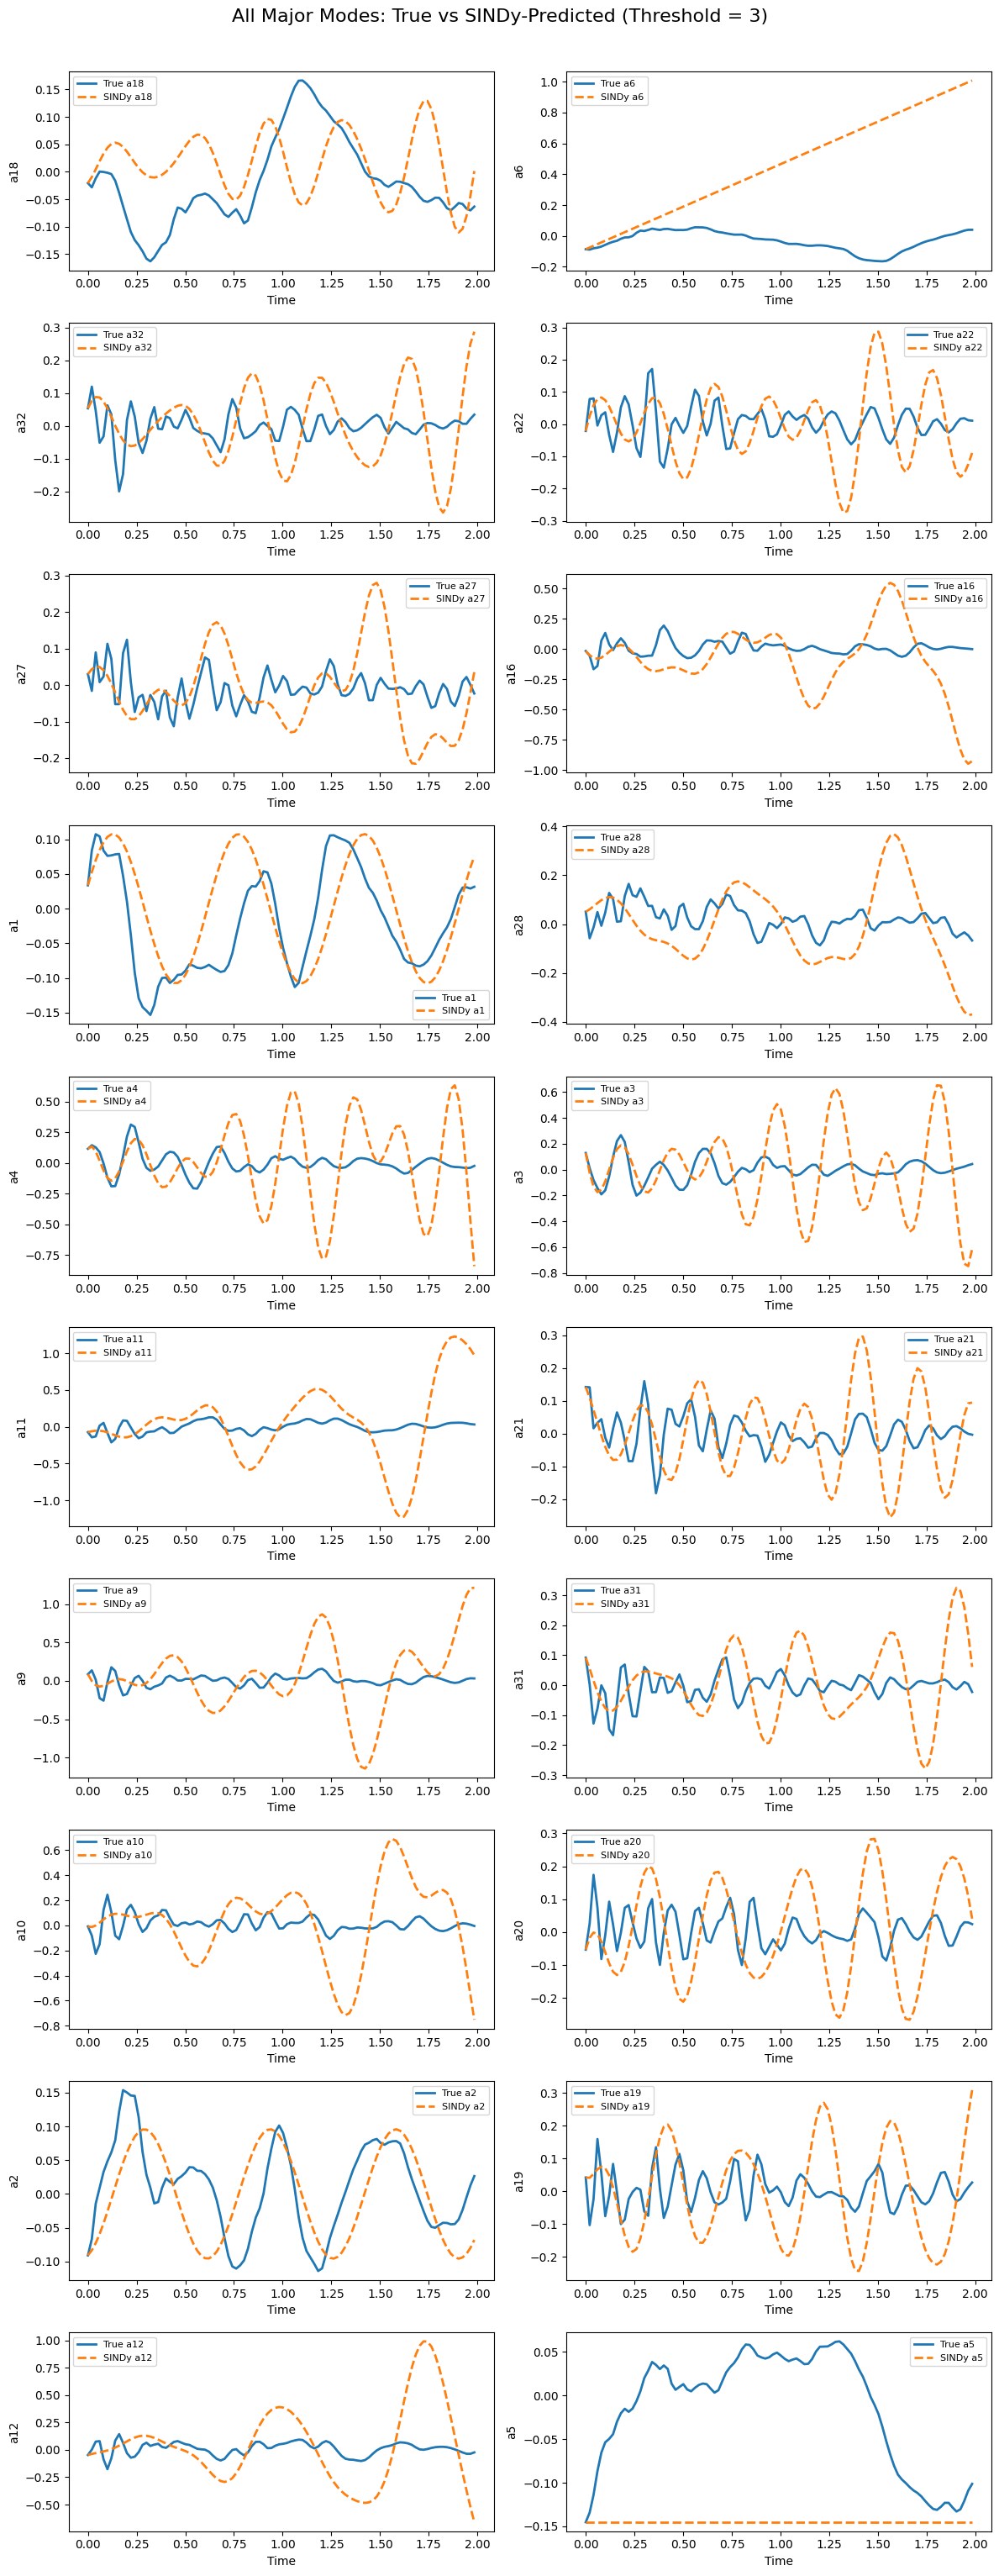

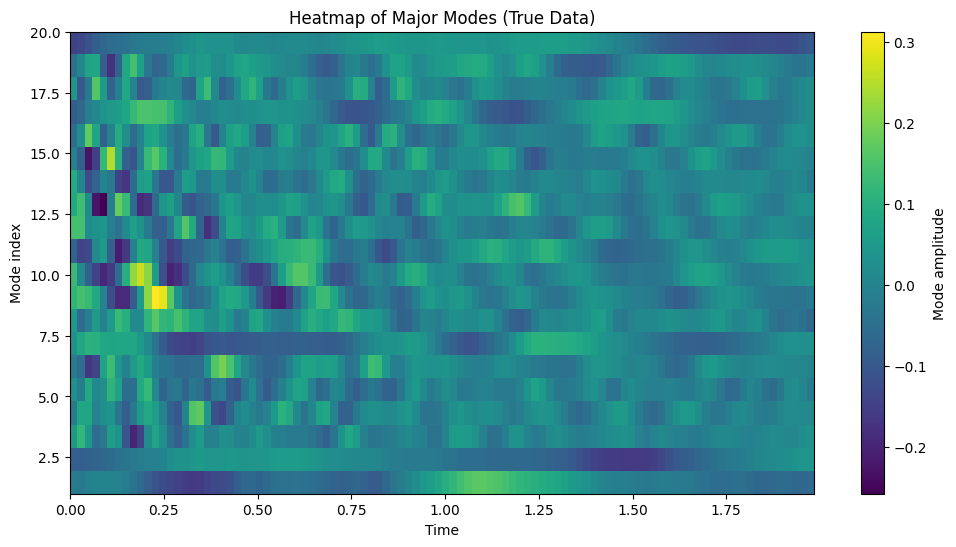

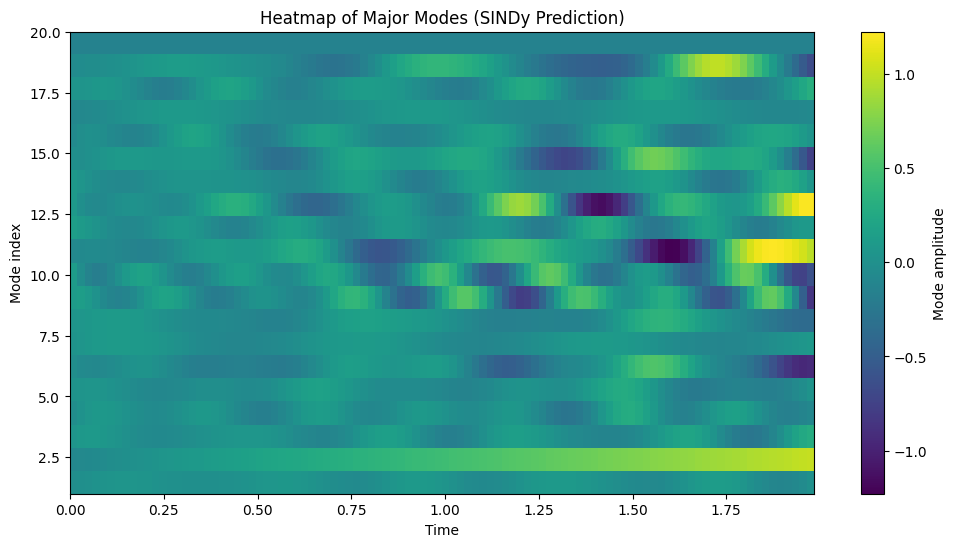

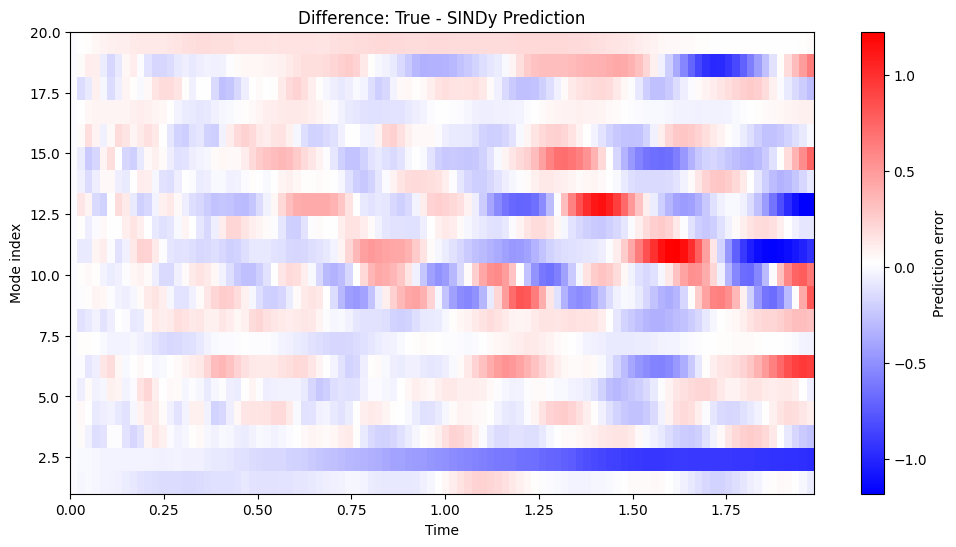

In [52]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from pysindy.differentiation import SmoothedFiniteDifference
from sklearn.decomposition import PCA

# Load .mat file
filepath = r"C:\Users\braid\OneDrive\Desktop\pysindy-master\examples\data\cavityGalerkin.mat"
data = sio.loadmat(filepath)

C = data['C'].flatten().astype(np.float32)
L = data['L'].astype(np.float32)
Q = data['Q'].astype(np.float32)
n_modes = C.shape[0]

# Define RHS
def galerkin_rhs(t, a):
    Q_sum = np.tensordot(Q, a, axes=([2],[0]))
    da = C + L @ a + Q_sum @ a
    return da

# Simulate full system
a0 = np.random.randn(n_modes).astype(np.float32) * 0.1
t_span = (0, 10)
t_eval = np.linspace(*t_span, 500, dtype=np.float32)

sol = solve_ivp(galerkin_rhs, t_span, a0, t_eval=t_eval)
A = sol.y.T.astype(np.float32)
t = sol.t.astype(np.float32)
print("Original A shape:", A.shape)

# Crop in time
nt_crop = 100
A_crop = A[:nt_crop, :]
t_crop = t[:nt_crop]

# PCA for mode selection / denoising
pca = PCA(n_components=0.95)  # keep 95% variance
pca.fit(A_crop)

print("Number of PCA components to capture 95% variance:", pca.n_components_)

mode_contrib = np.abs(pca.components_).sum(axis=0)
nmodes_major = 20
major_idx = np.argsort(mode_contrib)[-nmodes_major:]
print("Selected major physical modes (indices in original A):", major_idx)

A_major = A_crop[:, major_idx]
A_denoised = pca.inverse_transform(pca.transform(A_crop))[:, major_idx]

# Feature library and differentiation
feature_lib = ps.PolynomialLibrary(degree=2, include_bias=True)
diff_method = SmoothedFiniteDifference()

# Sparse regression using STLSQ
thresholds = [3]
best_sparsity = np.inf
best_model = None

for thresh in thresholds:
    optimizer = ps.STLSQ(threshold=thresh)
    model = ps.SINDy(
        feature_library=feature_lib,
        optimizer=optimizer,
        differentiation_method=diff_method
    )
    model.fit(A_denoised, t=t_crop, feature_names=[f"a{i+1}" for i in major_idx])
    sparsity = np.sum(model.coefficients() != 0)
    print(f"Threshold {thresh}: sparsity = {sparsity}")
    if sparsity < best_sparsity:
        best_sparsity = sparsity
        best_model = model
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh}")
best_model.print()

# Compare true vs predicted (line plots)
A_pred = best_model.simulate(A_denoised[0], t=t_crop)

nmodes_to_plot = A_denoised.shape[1]
ncols = 2
nrows = int(np.ceil(nmodes_to_plot / ncols))
plt.figure(figsize=(12, 3*nrows))
for i in range(nmodes_to_plot):
    plt.subplot(nrows, ncols, i+1)
    plt.plot(t_crop, A_denoised[:, i], label=f"True a{major_idx[i]+1}", lw=2)
    plt.plot(t_crop, A_pred[:, i], '--', label=f"SINDy a{major_idx[i]+1}", lw=2)
    plt.xlabel("Time")
    plt.ylabel(f"a{major_idx[i]+1}")
    plt.legend(fontsize=8)
    plt.tight_layout()
plt.suptitle(f"All Major Modes: True vs SINDy-Predicted (Threshold = {best_thresh})", y=1.02, fontsize=16)
plt.show()

# Heatmap of all major modes (True)
plt.figure(figsize=(12,6))
plt.imshow(A_denoised.T, aspect='auto', extent=[t_crop[0], t_crop[-1], 1, nmodes_major], origin='lower')
plt.colorbar(label='Mode amplitude')
plt.xlabel('Time')
plt.ylabel('Mode index')
plt.title('Heatmap of Major Modes (True Data)')
plt.show()

# Heatmap of all major modes (SINDy Prediction)
plt.figure(figsize=(12,6))
plt.imshow(A_pred.T, aspect='auto', extent=[t_crop[0], t_crop[-1], 1, nmodes_major], origin='lower')
plt.colorbar(label='Mode amplitude')
plt.xlabel('Time')
plt.ylabel('Mode index')
plt.title('Heatmap of Major Modes (SINDy Prediction)')
plt.show()

# Difference heatmap
plt.figure(figsize=(12,6))
plt.imshow((A_denoised - A_pred).T, aspect='auto', extent=[t_crop[0], t_crop[-1], 1, nmodes_major], origin='lower', cmap='bwr')
plt.colorbar(label='Prediction error')
plt.xlabel('Time')
plt.ylabel('Mode index')
plt.title('Difference: True - SINDy Prediction')
plt.show()


Original A shape: (500, 64)
Number of PCA components to capture 95% variance: 24
Selected major physical modes (indices in original A): [28  2  0  6 27 11 12 29  1 46 22 47 13 24 25  3  9  8 59 58]
Threshold 4: sparsity = 36

Best threshold: 4
(a29)' = 6.891 a3 + 8.307 a12 + 6.414 a59
(a3)' = -19.562 a4
(a1)' = -12.526 a2
(a7)' = -6.998 a12 + -6.626 a10 + -9.835 a59
(a28)' = 8.815 a3 + 7.505 a12 + 5.141 a59
(a12)' = 0.000
(a13)' = 6.001 a29 + -9.502 a12 + 11.640 a14 + 14.918 a10 + -4.773 a59
(a30)' = -11.698 a29 + -8.434 a10
(a2)' = 10.055 a1
(a47)' = 8.904 a48
(a23)' = 7.575 a3 + 10.423 a13 + 7.518 a9
(a48)' = -6.317 a47
(a14)' = -4.521 a3 + -7.185 a12 + -10.783 a13 + 13.630 a10
(a25)' = 0.000
(a26)' = 7.438 a25
(a4)' = 20.629 a3
(a10)' = 4.987 a12 + -9.471 a9
(a9)' = -10.422 a12 + 27.993 a10
(a60)' = -10.225 a59
(a59)' = 15.511 a60


c:\Users\braid\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\optimizers\stlsq.py:234: UserWarning: Sparsity parameter is too big (4) and eliminated all coefficients
  warnings.warn(
c:\Users\braid\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\optimizers\stlsq.py:234: UserWarning: Sparsity parameter is too big (4) and eliminated all coefficients
  warnings.warn(
c:\Users\braid\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\optimizers\stlsq.py:234: UserWarning: Sparsity parameter is too big (4) and eliminated all coefficients
  warnings.warn(
c:\Users\braid\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\optimizers\stlsq.py:234: UserWarning: Sparsity parameter is too big (4) and eliminated all coefficients
  warnings.warn(
c:\Users\braid\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\optimizers\stlsq.py:234: UserWarning: Sparsity parameter is too big (4) and eliminated all coefficients
  warni

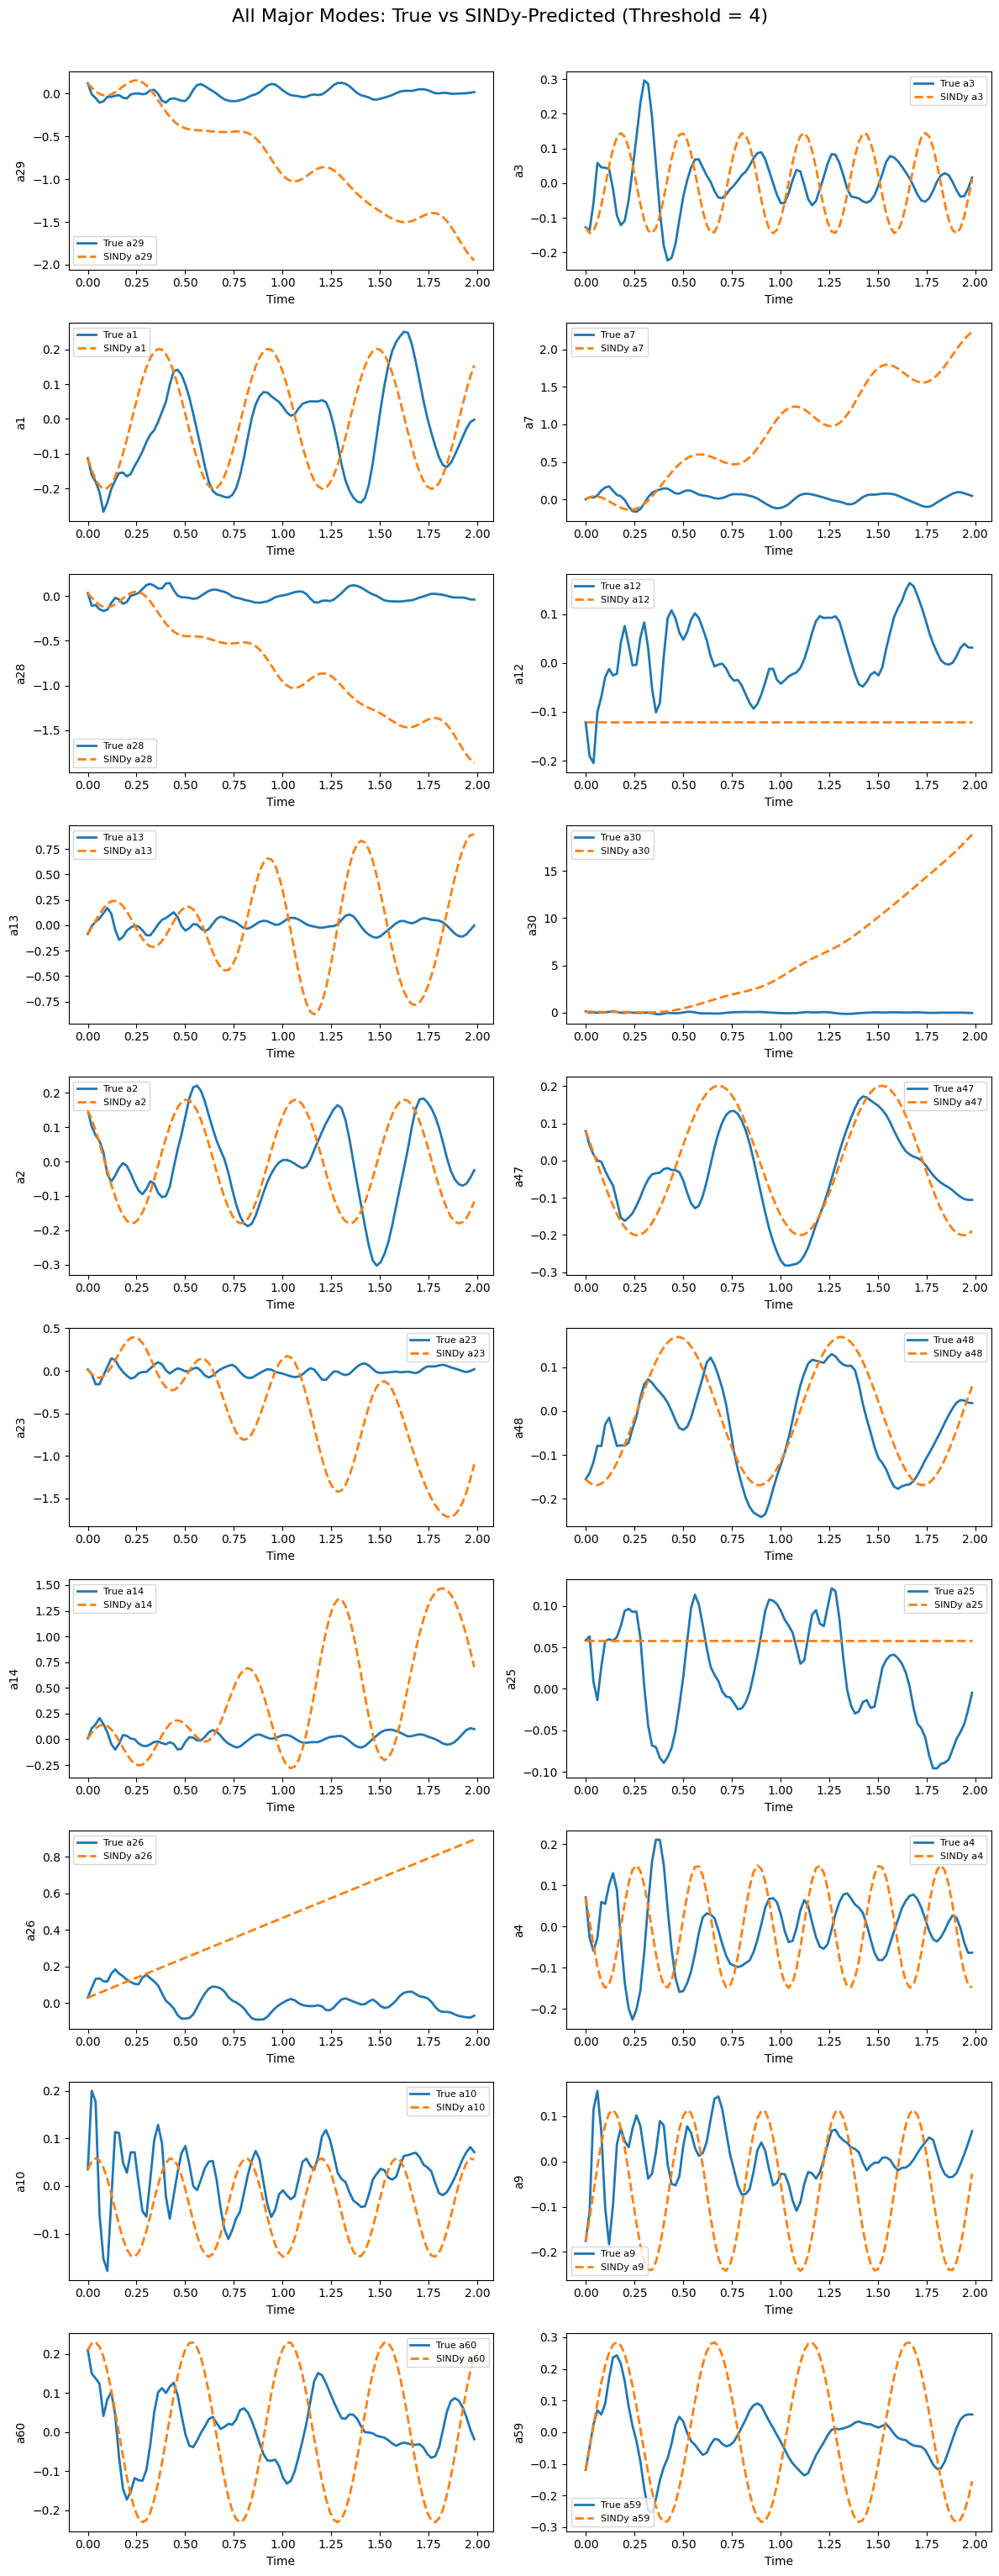

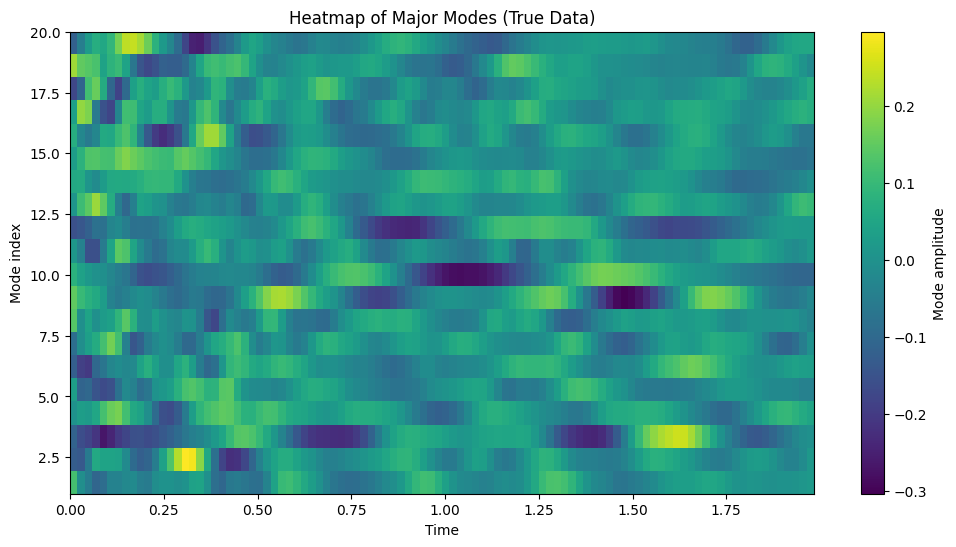

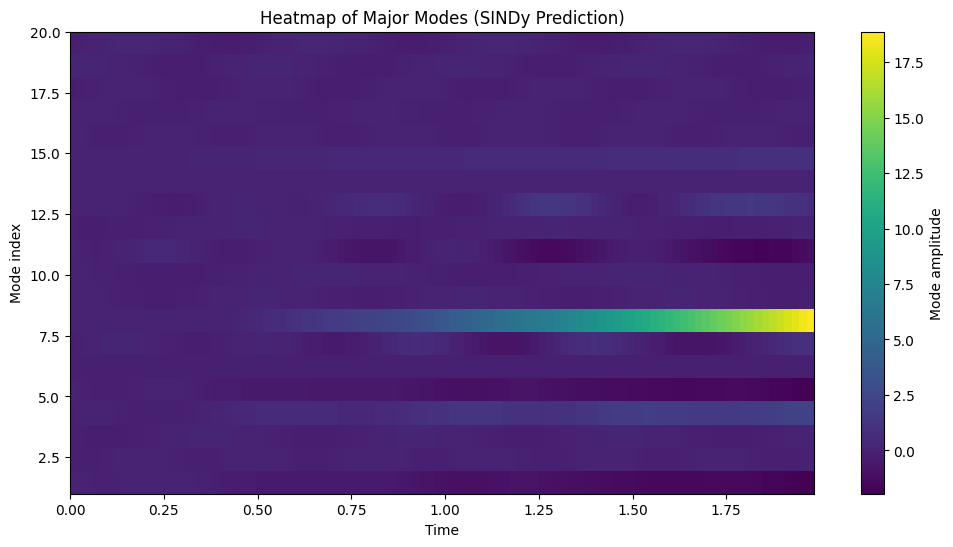

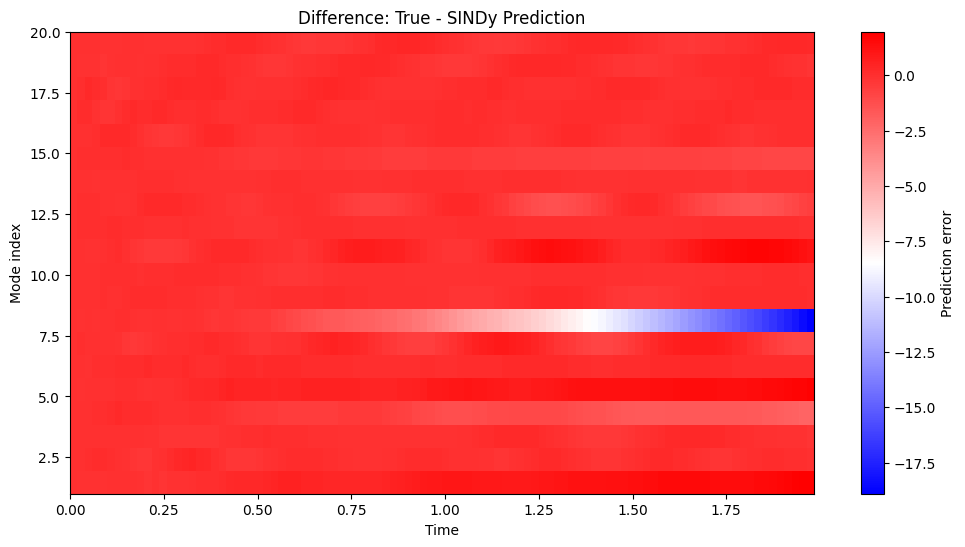

In [54]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from pysindy.differentiation import SmoothedFiniteDifference
from sklearn.decomposition import PCA

# Load .mat file
filepath = r"C:\Users\braid\OneDrive\Desktop\pysindy-master\examples\data\cavityGalerkin.mat"
data = sio.loadmat(filepath)

C = data['C'].flatten().astype(np.float32)
L = data['L'].astype(np.float32)
Q = data['Q'].astype(np.float32)
n_modes = C.shape[0]

# Define RHS
def galerkin_rhs(t, a):
    Q_sum = np.tensordot(Q, a, axes=([2],[0]))
    da = C + L @ a + Q_sum @ a
    return da

# Simulate full system
a0 = np.random.randn(n_modes).astype(np.float32) * 0.1
t_span = (0, 10)
t_eval = np.linspace(*t_span, 500, dtype=np.float32)

sol = solve_ivp(galerkin_rhs, t_span, a0, t_eval=t_eval)
A = sol.y.T.astype(np.float32)
t = sol.t.astype(np.float32)
print("Original A shape:", A.shape)

# Crop in time
nt_crop = 100
A_crop = A[:nt_crop, :]
t_crop = t[:nt_crop]

# PCA for mode selection / denoising
pca = PCA(n_components=0.95)  # keep 95% variance
pca.fit(A_crop)

print("Number of PCA components to capture 95% variance:", pca.n_components_)

mode_contrib = np.abs(pca.components_).sum(axis=0)
nmodes_major = 20
major_idx = np.argsort(mode_contrib)[-nmodes_major:]
print("Selected major physical modes (indices in original A):", major_idx)

A_major = A_crop[:, major_idx]
A_denoised = pca.inverse_transform(pca.transform(A_crop))[:, major_idx]

# Feature library and differentiation
feature_lib = ps.PolynomialLibrary(degree=2, include_bias=True)
diff_method = SmoothedFiniteDifference()

# Sparse regression using STLSQ
thresholds = [4]
best_sparsity = np.inf
best_model = None

for thresh in thresholds:
    optimizer = ps.STLSQ(threshold=thresh)
    model = ps.SINDy(
        feature_library=feature_lib,
        optimizer=optimizer,
        differentiation_method=diff_method
    )
    model.fit(A_denoised, t=t_crop, feature_names=[f"a{i+1}" for i in major_idx])
    sparsity = np.sum(model.coefficients() != 0)
    print(f"Threshold {thresh}: sparsity = {sparsity}")
    if sparsity < best_sparsity:
        best_sparsity = sparsity
        best_model = model
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh}")
best_model.print()

# Compare true vs predicted (line plots)
A_pred = best_model.simulate(A_denoised[0], t=t_crop)

nmodes_to_plot = A_denoised.shape[1]
ncols = 2
nrows = int(np.ceil(nmodes_to_plot / ncols))
plt.figure(figsize=(12, 3*nrows))
for i in range(nmodes_to_plot):
    plt.subplot(nrows, ncols, i+1)
    plt.plot(t_crop, A_denoised[:, i], label=f"True a{major_idx[i]+1}", lw=2)
    plt.plot(t_crop, A_pred[:, i], '--', label=f"SINDy a{major_idx[i]+1}", lw=2)
    plt.xlabel("Time")
    plt.ylabel(f"a{major_idx[i]+1}")
    plt.legend(fontsize=8)
    plt.tight_layout()
plt.suptitle(f"All Major Modes: True vs SINDy-Predicted (Threshold = {best_thresh})", y=1.02, fontsize=16)
plt.show()

# Heatmap of all major modes (True)
plt.figure(figsize=(12,6))
plt.imshow(A_denoised.T, aspect='auto', extent=[t_crop[0], t_crop[-1], 1, nmodes_major], origin='lower')
plt.colorbar(label='Mode amplitude')
plt.xlabel('Time')
plt.ylabel('Mode index')
plt.title('Heatmap of Major Modes (True Data)')
plt.show()

# Heatmap of all major modes (SINDy Prediction)
plt.figure(figsize=(12,6))
plt.imshow(A_pred.T, aspect='auto', extent=[t_crop[0], t_crop[-1], 1, nmodes_major], origin='lower')
plt.colorbar(label='Mode amplitude')
plt.xlabel('Time')
plt.ylabel('Mode index')
plt.title('Heatmap of Major Modes (SINDy Prediction)')
plt.show()

# Difference heatmap
plt.figure(figsize=(12,6))
plt.imshow((A_denoised - A_pred).T, aspect='auto', extent=[t_crop[0], t_crop[-1], 1, nmodes_major], origin='lower', cmap='bwr')
plt.colorbar(label='Prediction error')
plt.xlabel('Time')
plt.ylabel('Mode index')
plt.title('Difference: True - SINDy Prediction')
plt.show()
